In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import random
random.seed(1100038344)
import survivalstan
import numpy as np
import pandas as pd
from stancache import stancache
from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/jacquelineburos/miniconda3/envs/python3/lib/python3.5/site-packages/Cython/Distutils/old_build_ext.py:30: UserWarning: Cython.Distutils.old_build_ext does not properly handle dependencies and is deprecated.
  "Cython.Distutils.old_build_ext does not properly handle dependencies "


/home/jacquelineburos/.local/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
INFO:stancache.seed:Setting seed to 1245502385


In [2]:
print(survivalstan.models.pem_survival_model_gamma)

/*  Variable naming:
 // dimensions
 N          = total number of observations (length of data)
 S          = number of sample ids
 T          = max timepoint (number of timepoint ids)
 M          = number of covariates
 
 // data
 s          = sample id for each obs
 t          = timepoint id for each obs
 event      = integer indicating if there was an event at time t for sample s
 x          = matrix of real-valued covariates at time t for sample n [N, X]
 obs_t      = observed end time for interval for timepoint for that obs
 
*/
// Jacqueline Buros Novik <jackinovik@gmail.com>


data {
  int<lower=1> N;
  int<lower=1> S;
  int<lower=1> T;
  int<lower=0> M;
  int<lower=1, upper=N> s[N];     // sample id
  int<lower=1, upper=T> t[N];     // timepoint id
  int<lower=0, upper=1> event[N]; // 1: event, 0:censor
  matrix[N, M] x;                 // explanatory vars
  real<lower=0> obs_t[N];         // observed end time for each obs
  real<lower=0> t_dur[T];
  real<lower=0> t_obs[T];
}
t

In [3]:
d = stancache.cached(
    survivalstan.sim.sim_data_exp_correlated,
    N=100,
    censor_time=20,
    rate_form='1 + sex',
    rate_coefs=[-3, 0.5],
)
d['age_centered'] = d['age'] - d['age'].mean()
d.head()

INFO:stancache.stancache:sim_data_exp_correlated: cache_filename set to sim_data_exp_correlated.cached.N_100.censor_time_20.rate_coefs_54462717316.rate_form_1 + sex.pkl


INFO:stancache.stancache:sim_data_exp_correlated: Loading result from cache


,age,sex,rate,true_t,t,event,index,age_centered
0,59,male,0.082085,20.948771,20.000000,False,0,4.18
1,58,male,0.082085,12.827519,12.827519,True,1,3.18
2,61,female,0.049787,27.018886,20.000000,False,2,6.18
3,57,female,0.049787,62.220296,20.000000,False,3,2.18
4,55,male,0.082085,10.462045,10.462045,True,4,0.18


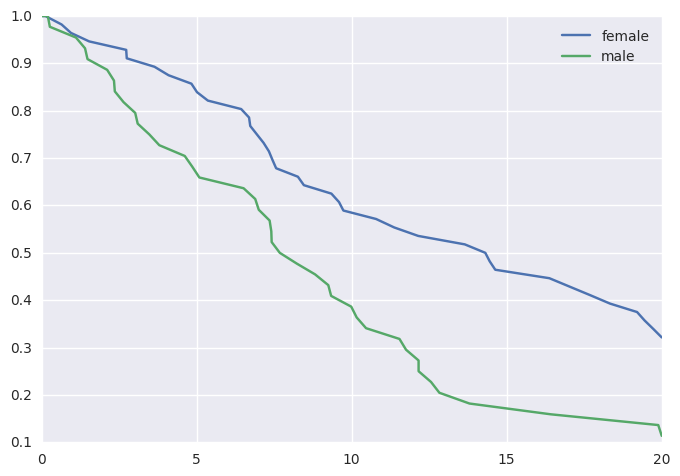

In [4]:
survivalstan.utils.plot_observed_survival(df=d[d['sex']=='female'], event_col='event', time_col='t', label='female')
survivalstan.utils.plot_observed_survival(df=d[d['sex']=='male'], event_col='event', time_col='t', label='male')
plt.legend()

In [5]:
dlong = stancache.cached(
    survivalstan.prep_data_long_surv,
    df=d, event_col='event', time_col='t'
)

INFO:stancache.stancache:prep_data_long_surv: cache_filename set to prep_data_long_surv.cached.df_33772694934.event_col_event.time_col_t.pkl


INFO:stancache.stancache:prep_data_long_surv: Loading result from cache


In [6]:
dlong.head()

,age,sex,rate,true_t,t,event,index,age_centered,key,end_time,end_failure
0,59,male,0.082085,20.948771,20.0,False,0,4.18,1,20.000000,False
1,59,male,0.082085,20.948771,20.0,False,0,4.18,1,12.827519,False
2,59,male,0.082085,20.948771,20.0,False,0,4.18,1,10.462045,False
3,59,male,0.082085,20.948771,20.0,False,0,4.18,1,0.196923,False
4,59,male,0.082085,20.948771,20.0,False,0,4.18,1,9.244121,False


In [7]:
testfit = survivalstan.fit_stan_survival_model(
    model_cohort = 'test model',
    model_code = survivalstan.models.pem_survival_model_gamma,
    df = dlong,
    sample_col = 'index',
    timepoint_end_col = 'end_time',
    event_col = 'end_failure',
    formula = '~ age_centered + sex',
    iter = 5000,
    chains = 4,
    seed = 9001,
    FIT_FUN = stancache.cached_stan_fit,
    )


INFO:stancache.stancache:Step 1: Get compiled model code, possibly from cache


INFO:stancache.stancache:StanModel: cache_filename set to anon_model.cython_0_25_1.model_code_72990130769.pystan_2_12_0_0.stanmodel.pkl


INFO:stancache.stancache:StanModel: Loading result from cache


INFO:stancache.stancache:Step 2: Get posterior draws from model, possibly from cache


INFO:stancache.stancache:sampling: cache_filename set to anon_model.cython_0_25_1.model_code_72990130769.pystan_2_12_0_0.stanfit.chains_4.data_64545635565.iter_5000.seed_9001.pkl


INFO:stancache.stancache:sampling: Starting execution


INFO:stancache.stancache:sampling: Execution completed (0:02:26.153391 elapsed)


INFO:stancache.stancache:sampling: Saving results to cache


/home/jacquelineburos/miniconda3/envs/python3/lib/python3.5/site-packages/stancache/stancache.py:251: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump(res, open(cache_filepath, 'wb'), pickle.HIGHEST_PROTOCOL)


/home/jacquelineburos/miniconda3/envs/python3/lib/python3.5/site-packages/stanity/psis.py:228: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif sort == 'in-place':
/home/jacquelineburos/miniconda3/envs/python3/lib/python3.5/site-packages/stanity/psis.py:246: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  bs /= 3 * x[sort[np.floor(n/4 + 0.5) - 1]]
/home/jacquelineburos/miniconda3/envs/python3/lib/python3.5/site-packages/stanity/psis.py:262: RuntimeWarning: overflow encountered in exp
  np.exp(temp, out=temp)


/home/jacquelineburos/miniconda3/envs/python3/lib/python3.5/site-packages/stanity/psis.py:246: RuntimeWarning: divide by zero encountered in true_divide
  bs /= 3 * x[sort[np.floor(n/4 + 0.5) - 1]]
/home/jacquelineburos/miniconda3/envs/python3/lib/python3.5/site-packages/stanity/psis.py:250: RuntimeWarning: invalid value encountered in multiply
  temp = ks[:,None] * x
/home/jacquelineburos/miniconda3/envs/python3/lib/python3.5/site-packages/stanity/psis.py:267: RuntimeWarning: invalid value encountered in greater_equal
  dii = w >= 10 * np.finfo(float).eps
/home/jacquelineburos/miniconda3/envs/python3/lib/python3.5/site-packages/stanity/psis.py:282: RuntimeWarning: invalid value encountered in double_scalars
  sigma = -k / b


In [8]:
survivalstan.utils.print_stan_summary([testfit], pars='lp__')

            mean  se_mean        sd         2.5%          50%       97.5%      Rhat
lp__ -1034.96497  0.18312  7.354494 -1050.563484 -1034.543604 -1021.53023  1.000819


In [9]:
survivalstan.utils.print_stan_summary([testfit], pars='log_baseline')

                        mean   se_mean          sd        2.5%         50%      97.5%      Rhat
log_baseline[0]    -5.540533  0.026349    1.317162   -8.741271   -5.317482  -3.605955  1.000660
log_baseline[1]    -5.540373  0.026410    1.312295   -8.765512   -5.305697  -3.661229  1.000160
log_baseline[2]    -5.533987  0.025182    1.277367   -8.563403   -5.341926  -3.613802  1.000899
log_baseline[3]    -5.499061  0.023197    1.266738   -8.526801   -5.300919  -3.598318  1.000996
log_baseline[4]    -5.529027  0.029142    1.376488   -8.883094   -5.280803  -3.553426  1.001002
log_baseline[5]    -5.471047  0.025521    1.260655   -8.429872   -5.272214  -3.596805  1.002028
log_baseline[6]    -5.499416  0.034998    1.321609   -8.548750   -5.291451  -3.584369  1.003210
log_baseline[7]    -5.464198  0.024734    1.288292   -8.466082   -5.228081  -3.575405  1.000619
log_baseline[8]    -5.466310  0.027385    1.284197   -8.583571   -5.262634  -3.536853  1.001117
log_baseline[9]    -5.416356  0.024357  

INFO:survivalstan.utils:Warning - 1 rows removed due to NaN values for Rhat. This may indicate a problem in your model estimation.


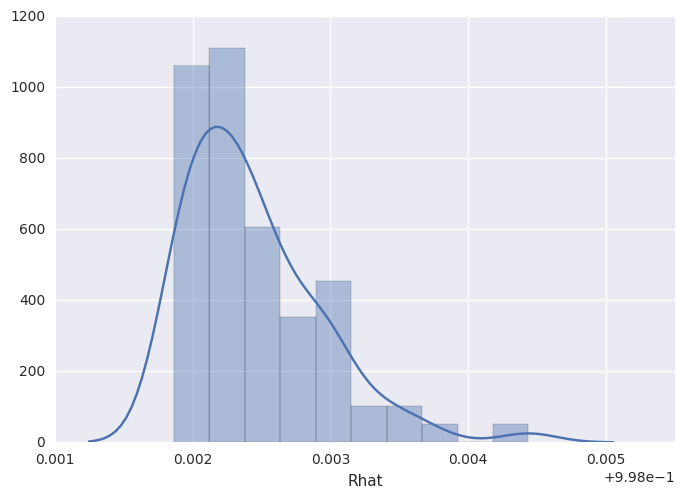

In [10]:
survivalstan.utils.plot_stan_summary([testfit], pars='baseline')

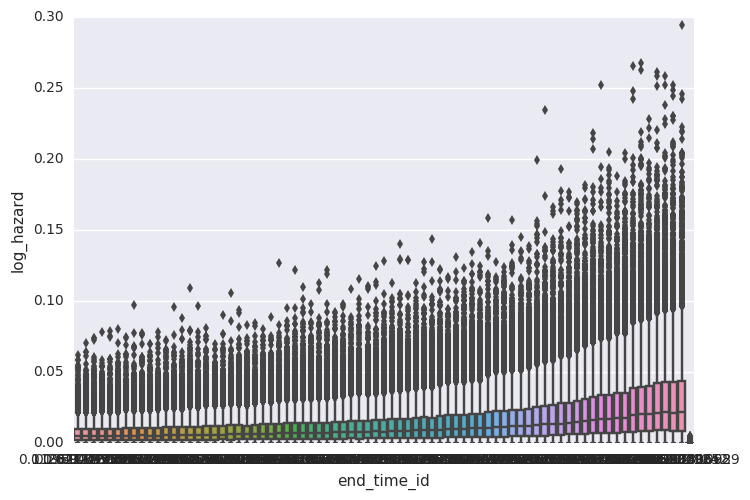

In [11]:
survivalstan.utils.plot_coefs([testfit], element='baseline')

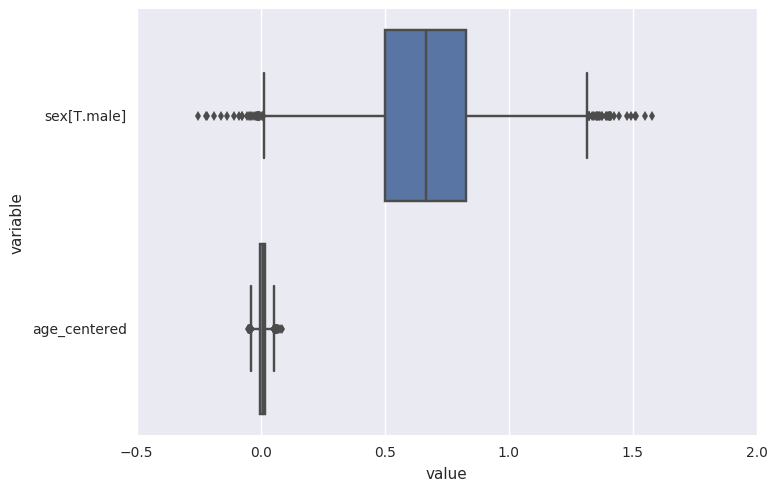

In [12]:
survivalstan.utils.plot_coefs([testfit])

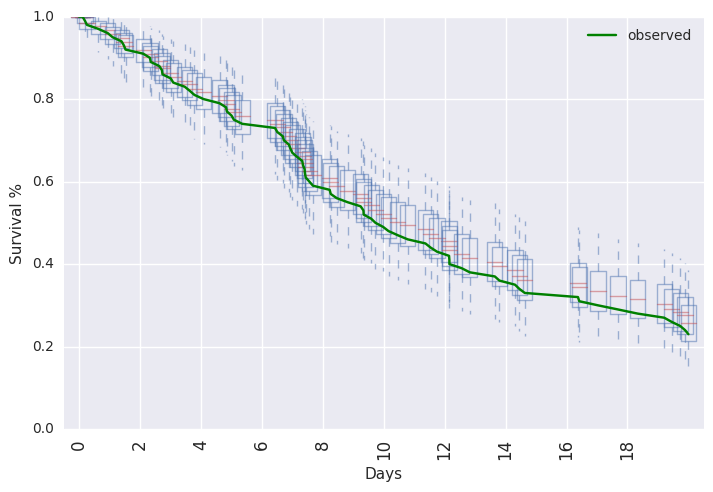

In [13]:
survivalstan.utils.plot_pp_survival([testfit], fill=False)
survivalstan.utils.plot_observed_survival(df=d, event_col='event', time_col='t', color='green', label='observed')
plt.legend()

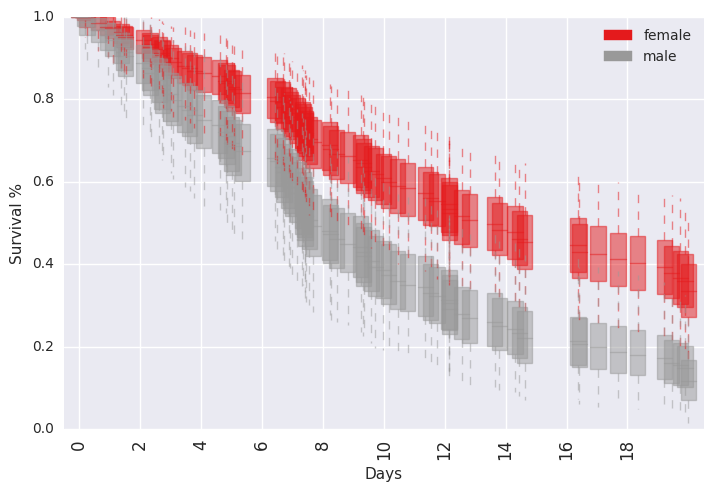

In [14]:
survivalstan.utils.plot_pp_survival([testfit], by='sex')

In [15]:
ppsurv = survivalstan.utils.prep_pp_survival_data([testfit], by='sex')

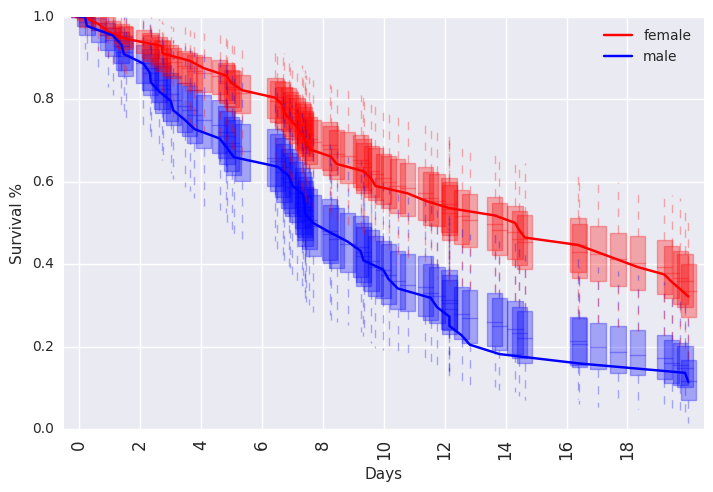

In [16]:
subplot = plt.subplots(1, 1)
survivalstan.utils._plot_pp_survival_data(ppsurv.query('sex == "male"').copy(),
                                          subplot=subplot, color='blue', alpha=0.3)
survivalstan.utils._plot_pp_survival_data(ppsurv.query('sex == "female"').copy(),
                                          subplot=subplot, color='red', alpha=0.3)
survivalstan.utils.plot_observed_survival(df=d[d['sex']=='female'], event_col='event', time_col='t',
                                          color='red', label='female')
survivalstan.utils.plot_observed_survival(df=d[d['sex']=='male'], event_col='event', time_col='t',
                                          color='blue', label='male')
plt.legend()